In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import pickle

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


- Data Exploration
- Datasets 
  - [llm-detect-ai-generated-text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text)
  - [additionnal data : daigt-v2-train-dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset)

- Cleaning
- Pre-Processing
- Modeling
- Saving

In [3]:
official_texts_df = pd.read_csv("../../raw_data/llm-detect-ai-generated-text/train_essays.csv")
official_texts_df

drcat_02_texts_df = pd.read_csv("../../raw_data/daigt-v2-train-dataset/train_v2_drcat_02.csv")
drcat_02_texts_df

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [4]:
genai_texts_df = pd.DataFrame(drcat_02_texts_df['text'].sample(1000))
genai_texts_df["generated"] = 1

In [5]:
official_non_generated_texts_df = official_texts_df[official_texts_df["generated"] == 0].sample(1000)
official_non_generated_texts_df = official_non_generated_texts_df[['text', 'generated']]
official_non_generated_texts_df.head(2)

,text,generated
80,"Dear state senator, There should be a change i...",0
1114,Does the Electoral College work? Are you happy...,0


In [6]:
texts_df = pd.concat(objs=[genai_texts_df, official_non_generated_texts_df])
texts_df

,text,generated
30839,"Hey there! \n\nSo, I reckon working in groups ...",1
3580,Student-Designed Summer Projects\n\nSchools ac...,1
31929,Being true to oneself is essential for a perso...,1
9805,Using technology to read students' emotional e...,1
37159,"Dear Manager,\n\nI would like to request a vi...",1
...,...,...
221,Cars are becoming a dying trend all over the w...,0
1115,Zroom! Cars have been developing for hundreds ...,0
988,"In today's society, most people believe that h...",0
67,Car usage all over the world has reduced and b...,0


In [7]:
def text_lenght(text):
    return len(text)

def average_sentences(text):
    return len(text.split("."))

texts_df['text_lenght'] = texts_df['text'].apply(text_lenght)
texts_df['sentences_count'] = texts_df['text'].apply(average_sentences)
texts_df.head(2)


,text,generated,text_lenght,sentences_count
30839,"Hey there! \n\nSo, I reckon working in groups ...",1,1839,15
3580,Student-Designed Summer Projects\n\nSchools ac...,1,4866,41


In [8]:
texts_df.groupby(['generated']).mean(text_lenght)

,text_lenght,sentences_count
generated,,
0,3148.729,29.728
1,2179.970,20.206


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

X = texts_df[['text_lenght', 'sentences_count']]
y = texts_df['generated']

model = LogisticRegression()

cv_results = cross_validate(model, X, y, cv=10)

print(cv_results['test_score'])

cv_results['test_score'].mean()


[0.695 0.75  0.74  0.75  0.72  0.755 0.755 0.715 0.745 0.725]


0.735

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
y_test, y_pred)
plt.show()

KeyboardInterrupt: 

zsh:1: command not found: gh api user | jq -r '.login'


In [51]:
# Save model

# save the model to disk
filename = '../../detect_ai_content/models/leverdewagon/finalized_genai_text_detection_model.pickle'
pickle.dump(model, open(filename, 'wb'))

In [16]:
def get_huggingface_texts(number):
    path = "../../raw_data/huggingface.co_human_ai_generated_text/model_training_dataset.csv"

    # Extract a small dataset
    chunksize = number
    huggingface_df = None

    for chunk in pd.read_csv(path, chunksize=chunksize):
        # chunk is a DataFrame. To "process" the rows in the chunk:
        huggingface_df = chunk
        break

    huggingface_human_text_df = huggingface_df[["id", "human_text"]]
    huggingface_human_text_df = huggingface_human_text_df.rename(columns={'human_text':'text'},)
    huggingface_human_text_df['generated'] = 0

    huggingface_ai_text_df = huggingface_df[["id", "ai_text"]]
    huggingface_ai_text_df = huggingface_ai_text_df.rename(columns={'ai_text':'text'},)
    huggingface_ai_text_df['generated'] = 1

    huggingface_sample_text_df = pd.concat(objs=[huggingface_human_text_df, huggingface_ai_text_df])
    return huggingface_sample_text_df

In [17]:
huggingface_sample_text_df = get_huggingface_texts(200)

huggingface_sample_text_df['text_lenght'] = huggingface_sample_text_df['text'].apply(text_lenght)
huggingface_sample_text_df['sentences_count'] = huggingface_sample_text_df['text'].apply(average_sentences)

# From String we Imorts Punctuation.
import string

# Mistakes https://textblob.readthedocs.io/en/dev/
from textblob import TextBlob
import nltk
nltk.download('punkt_tab')

def punctuation_count(text):
    blob = TextBlob(text)
    number_of_ponctuations = 0

    for c in text:
        if c in string.punctuation:
            number_of_ponctuations += 1

    return number_of_ponctuations / len(blob.sentences)

print("punctuation_count")
huggingface_sample_text_df['average_punctuation'] = huggingface_sample_text_df['text'].apply(punctuation_count)

def sentiment_polarity(text):
    blob = TextBlob(text)

    global_polarity = 0
    for sentence in blob.sentences:
        global_polarity += sentence.sentiment.polarity

    return global_polarity / len(blob.sentences)

print("sentiment_polarity")
huggingface_sample_text_df['global_sentiment_polarity'] = huggingface_sample_text_df['text'].apply(sentiment_polarity)

def sentiment_polarity(text, polarity="neg"):
    blob = TextBlob(text)

    global_polarity = 0
    for sentence in blob.sentences:
        if polarity == "neg" and sentence.sentiment.polarity < 0:
            global_polarity += sentence.sentiment.polarity
        if polarity == "pos" and sentence.sentiment.polarity > 0:
            global_polarity += sentence.sentiment.polarity
    return global_polarity / len(blob.sentences)

def neg_sentiment_polarity(text):
    return sentiment_polarity(text, polarity="neg")

def pos_sentiment_polarity(text):
    return sentiment_polarity(text, polarity="pos")

print("neg_sentiment_polarity")
huggingface_sample_text_df['global_neg_sentiment_polarity'] = huggingface_sample_text_df['text'].apply(neg_sentiment_polarity)
huggingface_sample_text_df['global_pos_sentiment_polarity'] = huggingface_sample_text_df['text'].apply(pos_sentiment_polarity)

def spelling_corrections(text):
    blob = TextBlob(text)
    number_of_corrections = 0
    for sentence in blob.sentences:
        if sentence != sentence.correct():
            number_of_corrections += 1

    return number_of_corrections / len(blob.sentences)

print("spelling_corrections")
huggingface_sample_text_df['global_spelling_corrections'] = huggingface_sample_text_df['text'].apply(spelling_corrections)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

X = huggingface_sample_text_df[['text_lenght',
                                'sentences_count',
                                'global_neg_sentiment_polarity',
                                'global_pos_sentiment_polarity',
                                'global_sentiment_polarity',
                                'average_punctuation',
                                'global_spelling_corrections'
                                ]]
y = huggingface_sample_text_df['generated']

model = LogisticRegression(max_iter=1000)

cv_results = cross_validate(model, X, y, cv=10)

print(cv_results['test_score'])

cv_results['test_score'].mean()


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jeromemorissard/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


punctuation_count
sentiment_polarity
neg_sentiment_polarity
spelling_corrections
[0.825 0.725 0.8   0.825 0.775 0.825 0.825 0.675 0.775 0.875]


np.float64(0.7925000000000001)

In [20]:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

X = huggingface_sample_text_df[[
                                'global_neg_sentiment_polarity',
                                'global_pos_sentiment_polarity',
                                'global_sentiment_polarity',
                                'average_punctuation',
                                'global_spelling_corrections'
                                ]]
y = huggingface_sample_text_df['generated']

model = LogisticRegression(max_iter=1000)

cv_results = cross_validate(model, X, y, cv=10)

print(cv_results['test_score'])

cv_results['test_score'].mean()

[0.475 0.6   0.425 0.55  0.625 0.525 0.575 0.45  0.6   0.6  ]


np.float64(0.5424999999999999)

In [28]:
huggingface_sample_text_df

,id,text,generated,text_lenght,sentences_count,average_punctuation,global_sentiment_polarity,global_neg_sentiment_polarity,global_pos_sentiment_polarity,global_spelling_corrections
0,cc902a20-27c4-4c18-8012-048a328206d1,Also they feel more comfortable at home. Some ...,0,2464,33,1.387097,0.232903,-0.021398,0.254301,0.354839
1,c4d2fbe3-e966-479d-89c4-62e1729b6255,"I can get another job to work on the weekends,...",0,2708,14,5.692308,0.129487,-0.040385,0.169872,0.692308
2,710f585e-5e98-42b8-81f6-265d7c934645,parents and school should agree on the desicio...,0,2581,22,2.136364,0.144886,-0.032955,0.177841,0.727273
3,e4db6c43-7b6b-4385-9b67-04652c71df0c,"Base in my experiences I'm growing, I try hard...",0,1799,14,2.642857,0.264281,-0.008929,0.273209,0.428571
4,7a48bcf1-cbb4-4f41-b99a-ea859c56afdf,Many people around the world have different ch...,0,1119,15,1.857143,0.094345,-0.026786,0.121131,0.214286
...,...,...,...,...,...,...,...,...,...,...
95,477be269-b51d-451a-bdc6-89cca5b76ffe,"For some, the commitment and pressures of regu...",1,1017,8,3.333333,0.154167,-0.008333,0.162500,0.666667
96,8e2d01fb-be00-4e24-8f72-46aa061983bf,"His character traits of helping others, giving...",1,1097,9,3.000000,0.162132,-0.028571,0.190703,0.714286
97,1adcc15a-2213-4c20-850b-c3cddcbc9fd4,"Ultimately, while it is intended to increase s...",1,774,7,2.833333,0.131944,0.000000,0.131944,0.333333
98,a4c640d5-c364-477b-bb2b-8bbc360e537b,It is worth noting that not everyone has acces...,1,1255,10,2.200000,0.194000,-0.005000,0.199000,0.700000


In [46]:
huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 0]['average_punctuation'].mean()

np.float64(2.5791934908837537)

In [47]:
huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 1]['average_punctuation'].mean()

np.float64(2.613296483745012)

In [64]:
test_text = huggingface_sample_text_df[huggingface_sample_text_df['id'] == '1adcc15a-2213-4c20-850b-c3cddcbc9fd4'][1:2]["text"]
test_text = test_text.values[0]
blob = TextBlob(test_text)

def number_of_corrections(sentence):
    corrections = 0
    for w in sentence.words:
        # print(f'w:{w}')
        # print(w.spellcheck())
        spellcheck = w.spellcheck()
        if len(spellcheck) > 1:
            if w != spellcheck[0][0]:
                corrections += 1

    return corrections

def average_text_corrections(text):
    text_blob = TextBlob(text)
    corrections = 0
    for sentence in text_blob.sentences:
        corrections += number_of_corrections(sentence)
    return corrections/len(blob.sentences)

print(average_text_corrections(test_text))

0.3333333333333333


In [65]:
huggingface_sample_text_df['average_text_corrections'] = huggingface_sample_text_df['text'].apply(average_text_corrections)

In [67]:
huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 1]['average_text_corrections'].median()

np.float64(0.6666666666666666)

In [68]:
huggingface_sample_text_df['average_sentences_lenght'] = huggingface_sample_text_df['text_lenght']/huggingface_sample_text_df['sentences_count']

<Axes: xlabel='average_sentences_lenght', ylabel='average_text_corrections'>

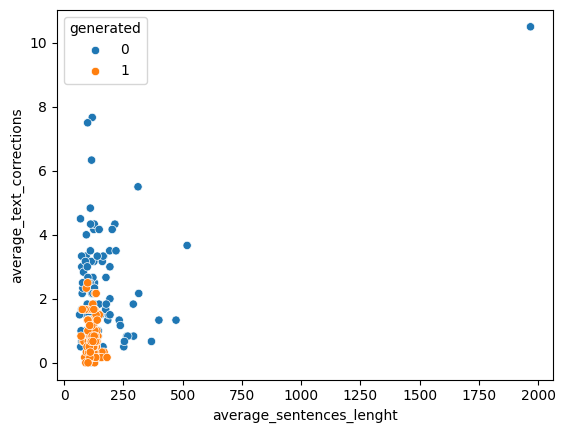

In [69]:
sns.scatterplot(data=huggingface_sample_text_df, x='average_sentences_lenght', y="average_text_corrections", hue="generated")

GPTZERO
OPENAI
WRITER
CROSSPLAG
COPYLEAKS
SAPLING
CONTENTATSCALE
ZEROGPT

In [70]:
huggingface_sample_text_df['global_abs_sentiment_polarity'] = abs(huggingface_sample_text_df['global_neg_sentiment_polarity']) + abs(huggingface_sample_text_df['global_pos_sentiment_polarity'])

In [78]:
huggingface_sample_text_df['global_sentiment_ratio_polarity'] = (1 + abs(huggingface_sample_text_df['global_pos_sentiment_polarity'])) / (1+ abs(huggingface_sample_text_df['global_neg_sentiment_polarity']))

In [83]:
# sns.scatterplot(data=huggingface_sample_text_df, x='average_sentences_lenght', y="global_sentiment_ratio_polarity", hue="generated")
huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 1]['global_sentiment_polarity'].median()

np.float64(0.15302884615384615)

In [84]:
# subjectivity ?

def subjectivity(text):
    blob = TextBlob(text)
    return blob.subjectivity

huggingface_sample_text_df['subjectivity'] = huggingface_sample_text_df['text'].apply(subjectivity)

In [86]:
huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 0]['subjectivity'].median()

np.float64(0.4854037253596078)

In [ ]:
# Répétitions ?


# Reverse BERT - if the next word is alway the more probable word ....


In [14]:
import numpy as np

from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import recall_score

print(f"{huggingface_sample_text_df.shape}")

# Feature/Target
X = huggingface_sample_text_df["text"]
y = huggingface_sample_text_df["generated"]

# Pipeline vectorizer + Naive Bayes
pipeline_naive_bayes = make_pipeline(
    TfidfVectorizer(),
    MultinomialNB()
)

# Cross-validation
cv_results = cross_validate(pipeline_naive_bayes, X, y, cv = 5, scoring = ["recall"])
average_recall = cv_results["test_recall"].mean()
np.round(average_recall,2)


(100000, 3)


np.float64(0.99)

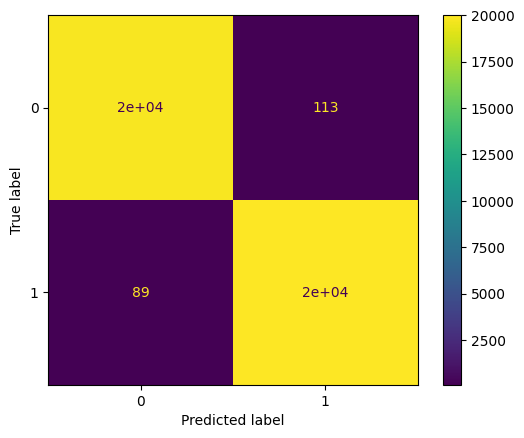

In [51]:
from sklearn.model_selection import train_test_split

huggingface_sample_text_df = get_huggingface_texts(100_000)

# Real training
X_train, X_test, y_train, y_test = train_test_split(huggingface_sample_text_df["text"], huggingface_sample_text_df["generated"], test_size=0.2)

model = pipeline_naive_bayes.fit(X=X_train, y=y_train)
y_pred = model.predict(X=X_test)

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
y_test, y_pred)
plt.show()

In [40]:
huggingface_sample_text_df = get_huggingface_texts(200)

huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 1]['text'].values

array(['\n\nTherefore, when it comes to allowing students the option to attend classes from home, there are intricacies that need to be taken into consideration in order to ensure that the best decision is made. Ultimately, this decision will depend on the individual student and their ability to take advantage of the opportunities available to them.. \n\nHowever, in the end, the effect that home-based classes will have on learning is largely dependent on the situation of the student. On the other hand, there could be a lack of social interaction with classmates, a lack of guidance from instructors, and potential technical issues as well. For example, those who are already motivated to learn and are self-disciplined may reap the full benefits of studying in the comfort of their own home. Conversely, for those who require more interaction and guidance that comes with physical classrooms, a home-based learning style may not be as effective. On the one hand, it eliminates the need for phys

In [54]:
# make a prediction ?

official_texts_df = pd.read_csv("../../raw_data/llm-detect-ai-generated-text/train_essays.csv")
official_generated_texts_df = official_texts_df[official_texts_df["generated"] == 1]
official_not_generated_texts_df = official_texts_df[official_texts_df["generated"] == 0]

# new_text = "La météo est un élément essentiel de notre quotidien. Elle influence non seulement notre humeur, mais également nos choix vestimentaires, nos activités extérieures, et même notre santé. Au printemps, les températures commencent à monter et les précipitations sont fréquentes, nourrissant les sols pour préparer l'été. L'été, quant à lui, apporte chaleur et soleil, bien que les orages puissent soudainement éclater, surtout en fin de journée. Avec l'automne vient une transition marquée par la chute des feuilles, une baisse des températures, et des pluies plus régulières. Enfin, l'hiver se caractérise par le froid, la neige et parfois le gel, rendant les paysages enchanteurs, mais aussi les déplacements plus délicats. Les prévisions météorologiques se sont améliorées grâce aux avancées technologiques, avec des satellites et des radars capables de surveiller l'atmosphère en temps réel. Aujourd'hui, nous pouvons connaître la météo jusqu'à plusieurs jours à l'avance, bien que celle-ci reste parfois imprévisible. Ces informations nous aident à anticiper et à nous préparer aux caprices de la nature, un élément incontournable de notre environnement."
# new_text_df = pd.DataFrame(data=[new_text], columns=['text'])
# print(new_text_df)

# new_texts_df = pd.DataFrame(data=huggingface_sample_text_df[huggingface_sample_text_df['generated'] == 1]['text'].values, columns=['text'])
new_y_pred = model.predict(X=official_not_generated_texts_df['text'])
# new_y_pred = model.predict(X=new_text_df['text'])
sum(new_y_pred)


np.int64(346)

In [58]:
official_generated_texts_df[0:1].text.value_counts()


text
This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elections. One of the reasons to keep the electoral college is that it is better for smaller, more rural states to have more influence as opposed to larger metropolitan areas that have large populations. The electors from these states are granted two votes each. Those from larger, more populated areas are granted just one vote each. Smaller states tend to hold significant power because their two votes for president and vice president add up more than the votes of larger states that have many electors. This is because of the split of the electoral votes. Some argue that electors are not bound to vote for the candidate who won the most votes nationally. They do not have to vote for their own state's nominee unless their state has a winner take all system. However, there are states that have adopted laws that force their electors to vote for their 

: 

In [2]:
# enrich_local_dataset
import os.path
import pandas as pd

from detect_ai_content.ml_logic.for_texts.using_ml_features.using_ml_features import enrich

# Extract a small dataset
target_dataset_size = 10000
actual_dataset_size = 0

chunksize = 10
huggingface_df = None

def save(df, path):
    if os.path.isfile(path) == False:
        df.to_csv(path, mode='a', index=True, header=True)
    else:
        df.to_csv(path, mode='a', index=True, header=False)

enrich_sample_path = "../../raw_data/huggingface.co_human_ai_generated_text/model_training_dataset_enriched.csv"

for chunk in pd.read_csv("../../raw_data/huggingface.co_human_ai_generated_text/model_training_dataset.csv", chunksize=chunksize):
    huggingface_df = chunk
    if actual_dataset_size > target_dataset_size:
        break

    huggingface_human_text_df = huggingface_df[["id", "human_text"]]
    huggingface_human_text_df = huggingface_human_text_df.rename(columns={'human_text':'text'},)
    huggingface_human_text_df['generated'] = 0

    huggingface_ai_text_df = huggingface_df[["id", "ai_text"]]
    huggingface_ai_text_df = huggingface_ai_text_df.rename(columns={'ai_text':'text'},)
    huggingface_ai_text_df['generated'] = 1

    huggingface_sample_text_df = pd.concat(objs=[huggingface_human_text_df, huggingface_ai_text_df])
    huggingface_sample_text_df = enrich(huggingface_sample_text_df)
    save(huggingface_sample_text_df, enrich_sample_path)
    actual_dataset_size += chunksize

    pourcent = int(100 * actual_dataset_size / target_dataset_size)
    print(f"{actual_dataset_size} on {target_dataset_size} ({pourcent}%)")

10 on 10000 (0%)
20 on 10000 (0%)
30 on 10000 (0%)
40 on 10000 (0%)
50 on 10000 (0%)
60 on 10000 (0%)
70 on 10000 (0%)
80 on 10000 (0%)
90 on 10000 (0%)
100 on 10000 (1%)
110 on 10000 (1%)
120 on 10000 (1%)
130 on 10000 (1%)
140 on 10000 (1%)
150 on 10000 (1%)
160 on 10000 (1%)
170 on 10000 (1%)
180 on 10000 (1%)
190 on 10000 (1%)
200 on 10000 (2%)
210 on 10000 (2%)
220 on 10000 (2%)
230 on 10000 (2%)
240 on 10000 (2%)
250 on 10000 (2%)
260 on 10000 (2%)
270 on 10000 (2%)
280 on 10000 (2%)
290 on 10000 (2%)
300 on 10000 (3%)
310 on 10000 (3%)
320 on 10000 (3%)
330 on 10000 (3%)
340 on 10000 (3%)
350 on 10000 (3%)
360 on 10000 (3%)
370 on 10000 (3%)
380 on 10000 (3%)
390 on 10000 (3%)
400 on 10000 (4%)
410 on 10000 (4%)
420 on 10000 (4%)
430 on 10000 (4%)
440 on 10000 (4%)
450 on 10000 (4%)
460 on 10000 (4%)
470 on 10000 (4%)
480 on 10000 (4%)
490 on 10000 (4%)
500 on 10000 (5%)
510 on 10000 (5%)
520 on 10000 (5%)
530 on 10000 (5%)
540 on 10000 (5%)
550 on 10000 (5%)
560 on 10000 (5%)
5

KeyboardInterrupt: 

In [ ]:
model_training_dataset_.csv